In [ ]:
%load_ext pycodestyle_magic
%pycodestyle_on

## Benchmarking
Diabetes dataset with 10 features plus 100 zero features

In [1]:
from shapley_algorithms.benchmark import compute_attributions
from shapley_algorithms.benchmark import cache_train
from sklearn import datasets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost
import pickle
import os

# Load data
exp_name = 'diabetes_addl_features'
dataset = datasets.load_diabetes()
X = pd.DataFrame(dataset['data'],
                 columns=dataset['feature_names'])
y = dataset['target']
# print(dataset['DESCR'])

# Add dummy features
for i in range(0, 100):
    X[f'dummy{i}'] = 0

# Train model
def train_fn(X, y):
    return xgboost.XGBRegressor(n_estimators=10, max_depth=5).fit(X, y)
cache_path = f'cache/{exp_name}/'
model = cache_train(train_fn, cache_path, X, y)

# Run benchmarking
num_evals_lst = [500, 1000, 5000, 10000, 50000, 100000]
explicand = X.values[0]
baselines = X.values[1:2]
results = compute_attributions(
    model, num_evals_lst, explicand, baselines, X, y, cache_path)
exact_attribution, attributions, evals_counts, runtimes = results

Loading from cache: (500, 'me')
Loading from cache: (1000, 'me')
Loading from cache: (5000, 'me')
Loading from cache: (10000, 'me')
Loading from cache: (50000, 'me')
Loading from cache: (100000, 'me')
Loading from cache: (500, 'me_rand')
Loading from cache: (1000, 'me_rand')
Loading from cache: (5000, 'me_rand')
Loading from cache: (10000, 'me_rand')
Loading from cache: (50000, 'me_rand')
Loading from cache: (100000, 'me_rand')
Loading from cache: (500, 'me_anti')
Loading from cache: (1000, 'me_anti')
Loading from cache: (5000, 'me_anti')
Loading from cache: (10000, 'me_anti')
Loading from cache: (50000, 'me_anti')
Loading from cache: (100000, 'me_anti')
Loading from cache: (500, 'mef')
Loading from cache: (1000, 'mef')
Loading from cache: (5000, 'mef')
Loading from cache: (10000, 'mef')
Loading from cache: (50000, 'mef')
Loading from cache: (100000, 'mef')
Loading from cache: (500, 'mef_rand')
Loading from cache: (1000, 'mef_rand')
Loading from cache: (5000, 'mef_rand')
Loading from c

## Investigate statistics and results

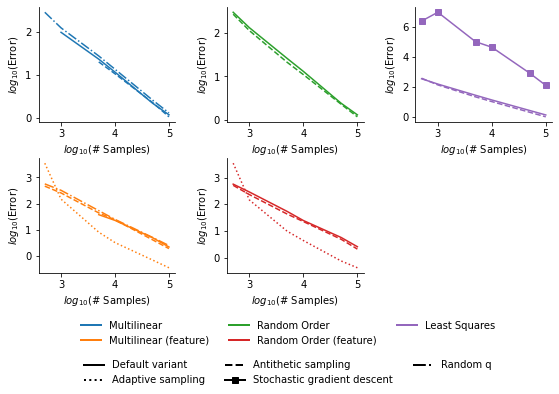

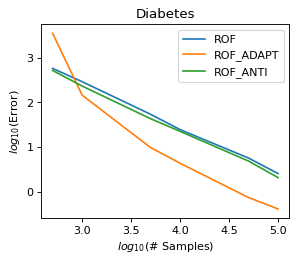

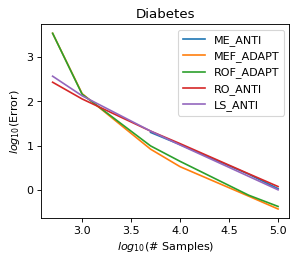

In [2]:
from shapley_algorithms.utils import gather_results
from shapley_algorithms.utils import plot_error_variants
from shapley_algorithms.utils import plot_indices

# Gather each dataframe for variance, bias, and error
var_df, bias_df, err_df = gather_results(
    num_evals_lst, exact_attribution, attributions)

# Plot subplot for each model agnostic approach and its variants for supp
plot_error_variants(num_evals_lst, err_df, cache_path)

# Plot the error within ROF only for maintext
indices = ['ROF', 'ROF_ANTI', 'ROF_ADAPT']
plot_indices(num_evals_lst, indices, err_df, 'Error', 'Diabetes', 
             cache_path, 'rof_error.pdf')

# Plot the error of the "best" variant within each model agnostic approach
prefixes = ['ME', 'MEF', 'ROF', 'RO', 'LS']
best_inds = []
for prefix in prefixes:
    valid_inds = []
    for ind in err_df.index:
        if ind.startswith(prefix+'_') or ind == prefix:
            valid_inds.append(ind)
    best_ind = err_df.loc[valid_inds][100000].argmin()
    best_inds.append(valid_inds[best_ind])

plot_indices(num_evals_lst, best_inds, err_df, 'Error', 'Diabetes', 
             cache_path, 'top_error.pdf')

# Save each dataframe as a csv file
bias_df.round(5).to_csv(cache_path + 'bias.csv')
var_df.round(5).to_csv(cache_path + 'variance.csv')
err_df.round(5).to_csv(cache_path + 'error.csv')

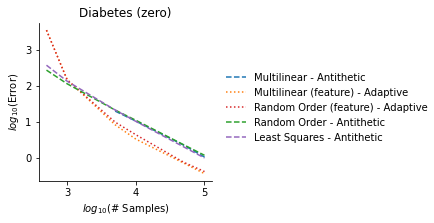

In [9]:
from shapley_algorithms.utils import variant_map
from shapley_algorithms.utils import color_map

ylabel = 'Error'
title = 'Diabetes (zero)'
method_names = {
    'ME': 'Multilinear',
    'MEF': 'Multilinear (feature)',
    'RO': 'Random Order',
    'ROF': 'Random Order (feature)',
    'LS': 'Least Squares',
}

variant_names = {
    'NONE': 'Default',
    'ADAPT': 'Adaptive',
    'ANTI': 'Antithetic',
    'SGD': 'SGD',
    'RAND': 'Random q',
}

prefixes = ['ME', 'MEF', 'ROF', 'RO', 'LS']
best_inds = []
for prefix in prefixes:
    valid_inds = []
    for ind in err_df.index:
        if ind.startswith(prefix+'_') or ind == prefix:
            valid_inds.append(ind)
    best_ind = err_df.loc[valid_inds][100000].argmin()
    best_inds.append(valid_inds[best_ind])

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3.2))
for index, row in err_df.iterrows():

    if index in best_inds:
        curr_method = index.split("_")[0]

        variant = 'NONE'
        if "_" in index: 
            variant = index.split("_")[1]

        label_full = method_names[curr_method] + ' - '
        label_full += variant_names[variant]
        ax.plot(
            np.log10(num_evals_lst), np.log10(row), variant_map[variant], 
                label=label_full, color=color_map[curr_method]
        )
        ax.set_xlabel("$log_{10}$(# Samples)")
        ax.set_ylabel("$log_{10}$" + f"({ylabel})")
        ax.set_title(title)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

fig.tight_layout()
fig.subplots_adjust(wspace=.7)
fig.subplots_adjust(right=.5)   ##  Need to play with this number.
fig.legend(loc='center right', bbox_to_anchor=(1.01, 0.5), 
           frameon=False)
plt.savefig(cache_path+"top_error.pdf")

plt.show()